# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops
from object_detection.builders import model_builder
from google.protobuf import text_format
import tensorflow as tf
from object_detection.protos import model_pb2
import time
from IPython.display import clear_output
from keras.models import load_model
from math import floor, ceil

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


/home/wc-gpu/MasterThesis/models/research/object_detection/utils/visualization_utils.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/wc-gpu/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/wc-gpu/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/wc-gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/wc-gpu/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/wc-gpu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
from utils import label_map_util

from utils import visualization_utils as vis_util

../utils/visualization_utils.py:26: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/wc-gpu/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/wc-gpu/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/wc-gpu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/wc-gpu/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/wc-gpu/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/wc

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [4]:
# What model to download.
MODEL_NAME = '../prod_faster_rcnn_resnet50_coco'
# MODEL_NAME = 'faster_rcnn_resnet50_coco_2018_01_28'
# MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2018_01_28'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
test_image_path = "/home/wc-gpu/MasterThesis/session_data/122923_testing"
# test_image_path = "/Users/mbaltac/Home/MasterThesis/MasterThesis/labeled_images_shopping_sessions/labeled/122923_testing"
TEST_IMAGE_PATHS = sorted([os.path.join(test_image_path, f) for f in os.listdir(test_image_path) if f.endswith("jpg")])


# TEST_IMAGE_PATHS = [TEST_IMAGE_PATHS[0], TEST_IMAGE_PATHS[0]]


# Size, in inches, of the output images.
IMAGE_SIZE = (18, 12)

SESSIONS_PATH = "/home/wc-gpu/storage4tb/session_data_thesis/sessions160000_165000"

## Download Model

In [5]:
# opener = urllib.request.URLopener()
# opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
# tar_file = tarfile.open(MODEL_FILE)
# for file in tar_file.getmembers():
#   file_name = os.path.basename(file.name)
#   if 'frozen_inference_graph.pb' in file_name:
#     tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [6]:
# with tf.Graph().as_default():
#   od_graph_def = tf.GraphDef()
#   with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
#     serialized_graph = fid.read()
#     od_graph_def.ParseFromString(serialized_graph)
#     tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [7]:
# category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [8]:
category_index = {1: {'id': 1, 'name': 'product'},
 2: {'id': 2, 'name': 'add'},
 3: {'id': 3, 'name': 'remove'},
 4: {'id': 4, 'name': 'move_from'},
 5: {'id': 5, 'name': 'move_to'}}

## Helper code

In [9]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [10]:
def max_pool_dynamic_input(x, H_out, W_out):
    out = None
    (N, H, W, C) = x.shape
    pool_height = np.zeros((H_out), dtype="int32")
    pool_width = np.zeros((W_out), dtype="int32")
    
    div_h = int(H/H_out)
    mod_h = H%H_out
    div_w = int(W/W_out)
    mod_w = W%W_out
    pool_height = pool_height + div_h
    pool_width = pool_width + div_w
    pool_height[:mod_h] += 1
    pool_width[:mod_w] += 1
    
    out = np.zeros((N, H_out, W_out, C))
    for n in range(N):
        for h in range(H_out):
            for w in range(W_out):
                h1 = sum(pool_height[:h])
                h2 = h1 + pool_height[h]
                w1 = sum(pool_width[:w])
                w2 = w1 + pool_width[w]
                window = x[n, h1:h2, w1:w2, :]
                m = np.max(window, axis=0)
                m = np.max(m, axis=0)
                out[n,h,w,:] = m
    
    return out


def get_max_and_concat(*args):
    size = 0
    for arg in args:
        size += arg.shape[-1]
    final = np.zeros(size)
    
    arg_size = 0
    
    i = 0
    for arg in args:
        max_pool = max_pool_dynamic_input(np.expand_dims(arg, 0), 1, 1)[0,0,0,:]
        final[i: arg.shape[-1]+i] = max_pool
        i+= arg.shape[-1]  
    return final

def get_max_and_concat2(*args):
    size = 0
    for arg in args:
        size += arg.shape[-1]
    final = np.zeros(size)
    
    arg_size = 0

    for arg in args:
        for i in range(arg.shape[-1]):
            final[i+arg_size] = np.max(arg[:,:,i])
        arg_size += arg.shape[-1]
    
#     mn = np.mean(final)
#     std = np.std(final)
#     final = (final - mn)/std

    return final

def max_pooled(previous_features, features, label):
    box_prev = previous_features[
        floor(label[0]*previous_features.shape[0]):
        ceil(label[2]*previous_features.shape[0]), 
        floor(label[1]*previous_features.shape[1]):
        ceil(label[3]*previous_features.shape[1]),:]
    box_cur = features[
        floor(label[0]*features.shape[0]):
        ceil(label[2]*features.shape[0]), 
        floor(label[1]*features.shape[1]):
        ceil(label[3]*features.shape[1]),:]

    return get_max_and_concat(box_prev, previous_features, box_cur, features)

In [11]:
a=np.random.rand(12, 13, 1024)

In [12]:
b=np.random.rand(3, 4, 1024)

In [13]:
c = get_max_and_concat(a, b)

In [14]:
c1 = get_max_and_concat2(a,b)

In [15]:
sum(c==c1) - len(c)

0

In [16]:
c1

array([0.99346063, 0.99369764, 0.99487142, ..., 0.99781689, 0.9489089 ,
       0.97717628])

In [17]:
def get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    """

    b1y1, b1x1, b1y2, b1x2 = bb1
    b2y1, b2x1, b2y2, b2x2 = bb2

    b1y1, b1x1, b1y2, b1x2 = b1y1, b1x1, b1y1+b1y2, b1x1+b1x2
    b2y1, b2x1, b2y2, b2x2 = b2y1, b2x1, b2y1+b2y2, b2x1+b2x2

    b1y1, b1x1, b1y2, b1x2 = b1x1, b1y1, b1x2, b1y2
    b2y1, b2x1, b2y2, b2x2 = b2x1, b2y1, b2x2, b2y2
    
    # determine the coordinates of the intersection rectangle
    x_left = max(b1x1, b2x1)
    y_top = max(b1y1, b2y1)
    x_right = min(b1x2, b2x2)
    y_bottom = min(b1y2, b2y2)

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (b1x2 - b1x1) * (b1y2 - b1y1)
    bb2_area = (b2x2 - b2x1) * (b2y2 - b2y1)

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou > 0.0
    assert iou < 1.0
    return iou


def filter_detections(out_boxes, out_scores, iou_tresh = .5, score_tresh = 0.3):
    fboxes, fscores, fclasses = [], [], []
    removed = set()
    
    filter_score = np.where(out_scores > score_tresh)
    print (filter_score)
    
    for i, b in reversed(list(enumerate(out_boxes))):
        if i not in removed:
            max_score = out_scores[i]
            max_idx = i
            for j in range(i+1, len(out_boxes)):
                if j not in removed and get_iou(b, out_boxes[j]) > .65:
                    if out_scores[j] > max_score:
                        removed.add(max_idx)
                        max_idx = j
                        max_score = out_scores[j]
                    else:
                        removed.add(j)

    for i in range(len(out_boxes)):
        if i not in removed:
            fboxes.append(out_boxes[i])
            fscores.append(out_scores[i])
            fclasses.append(out_classes[i])

    return fboxes, fscores, fclasses

In [18]:
tf_config = tf.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.5

In [19]:
def run_inference_for_single_image(image):
    with tf.Session(config=tf_config) as sess:

      # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
        ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)
        features = tf.get_default_graph().get_tensor_by_name(
            'FirstStageFeatureExtractor/resnet_v1_50/resnet_v1_50/block3/unit_6/bottleneck_v1/Relu:0')

        tensor_dict['features'] = tf.expand_dims(features, 0)
        
        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

        # Run inference
        output_dict = sess.run(tensor_dict, 
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        output_dict['features'] = output_dict['features'][0][0]

        return output_dict

In [ ]:
def run_inference_for_batch(images):
    with tf.Session(config=tf_config) as sess:

      # Get handles to input and output tensors
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
        ]:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                  tensor_name)
        features = tf.get_default_graph().get_tensor_by_name(
            'FirstStageFeatureExtractor/resnet_v1_50/resnet_v1_50/block3/unit_6/bottleneck_v1/Relu:0')

        tensor_dict['features'] = tf.expand_dims(features, 0)
        
        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')
        
        # Run inference
        output_dict = sess.run(tensor_dict, 
                             feed_dict={image_tensor: np.array(images)})

        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        output_dict['features'] = output_dict['features'][0][0]

        return output_dict

In [20]:
# from keras import backend as K
# import tensorflow as tf

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
# session = tf.Session(config=config)


In [21]:
mn, std = np.load("./mn_std.pkl")

In [30]:
progress = 0

processed = 0
time_avg = 0

outputs = []

total_time = 0
box_predictions = []
tf.reset_default_graph()
with tf.Graph().as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    
#     ker_model = load_model(
#         "/home/wc-gpu/MasterThesis/models/research/object_detection/box_classification_checkpoint/keep/new_trained_one_class_acc0.86.hdf5")

    session_path = "/home/wc-gpu/storage4tb/session_data_thesis/sessions160000_165000/122979/"
#     session_path = "/home/wc-gpu/MasterThesis/session_data/122923_testing"

    images = sorted([f for f in os.listdir(session_path) if f.endswith(".jpg")])
    total_images = len(images)
    prev_features = None
    for image_fname in images:
        has_processed = False
        try:
            t0 = time.time()
            image_path = os.path.join(session_path, image_fname)

            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)

            output_dict = run_inference_for_single_image(image_np)
            
            keep = np.where(output_dict['detection_scores'] > 0.1)
            
            output_dict['detection_boxes'] = output_dict['detection_boxes'][keep]
            output_dict['detection_classes'] = output_dict['detection_classes'][keep]
            output_dict['detection_scores'] = output_dict['detection_scores'][keep]
            
#             if prev_features is not None:
#                 box_features = []
#                 for b in output_dict['detection_boxes']:
#                     box_features.append(max_pooled(prev_features,  output_dict['features'], b))
                
#                 box_features = np.array(box_features)
                
#                 box_features = (box_features - mn)/std

#                 box_prediction = ker_model.predict(box_features)
# #                 classes = np.argmax(box_prediction, 1)
# #                 scores = []
# #                 for i, s in enumerate(box_prediction):
# #                     scores.append(s[classes[i]])                
# #                 scores = np.array(scores)
#                 box_predictions.append(box_prediction.flatten())
                
#                 output_dict['detection_scores'] *= box_prediction.flatten()
# #                 output_dict['detection_classes'] = classes + 1
                
#                 has_processed = True
#                 processed += 1
                
            outputs.append((image_np, output_dict))
            prev_features = output_dict['features']            
            
        except Exception as ex:
            print ("IMAGE ", image_fname)
            print (str(ex))
            raise ex


        t1 = time.time()

        total = t1-t0
        
        if has_processed:
            time_avg = (total_time + total) / processed
        
        total_time += total
        
        log_text = " ".join(["progress ", ":", str(progress / total_images), 
                             str(progress), str(total_images)])
        log_text += " | "

        log_text += "".join(["process time ", str(total)])
        log_text += " | "
        log_text += "".join([" time passed: ", str(time_avg*processed) ," s, remaining: ", str(time_avg* (total_images - progress) ), " s"])
            

        print (log_text, end="                                       \r")

        progress += 1
        

# log.close()

In [23]:
# for image_np, output_dict in outputs:
#     output_dict["detection_scores"] = np.array(output_dict["detection_scores"])
#     print (output_dict["detection_scores"])
# c = np.argmax(box_predictions[0], 1)
# c = np.argmax(box_predictions[0], 1)
# scores = []
# for i, s in enumerate(box_predictions[0]):
#     scores.append(s[c[i]])

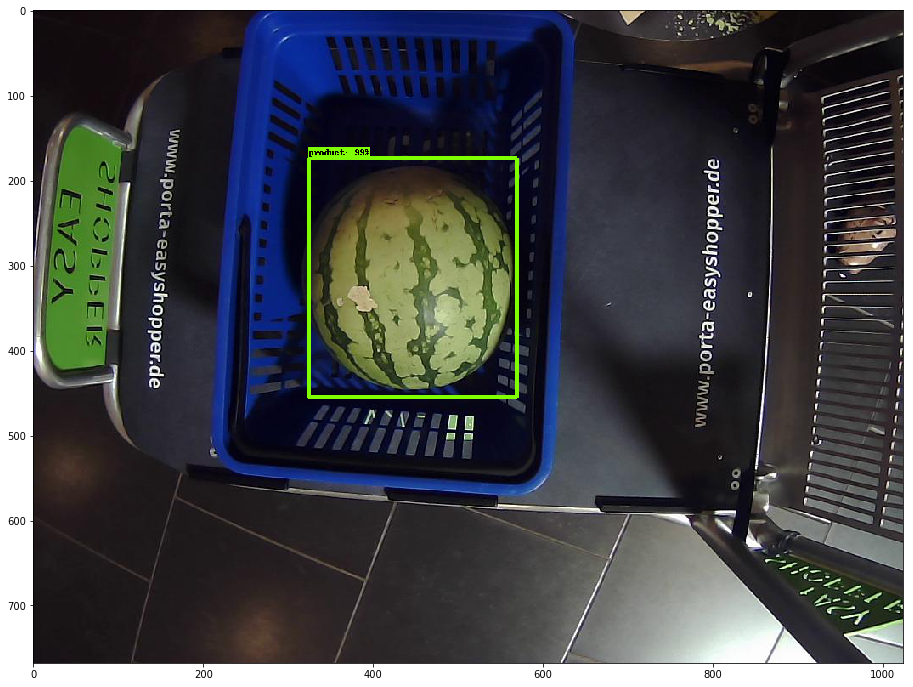

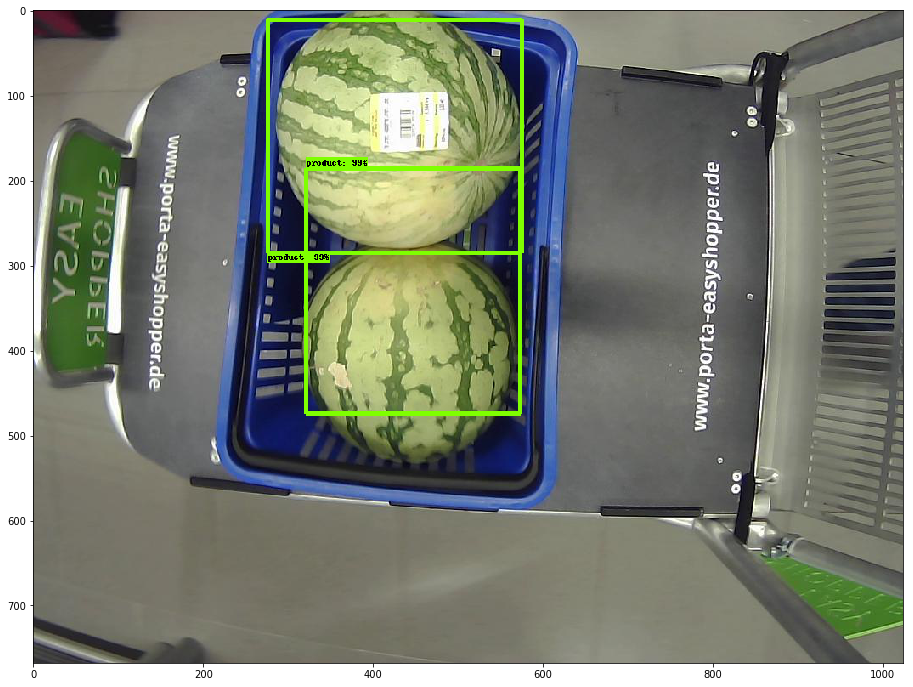

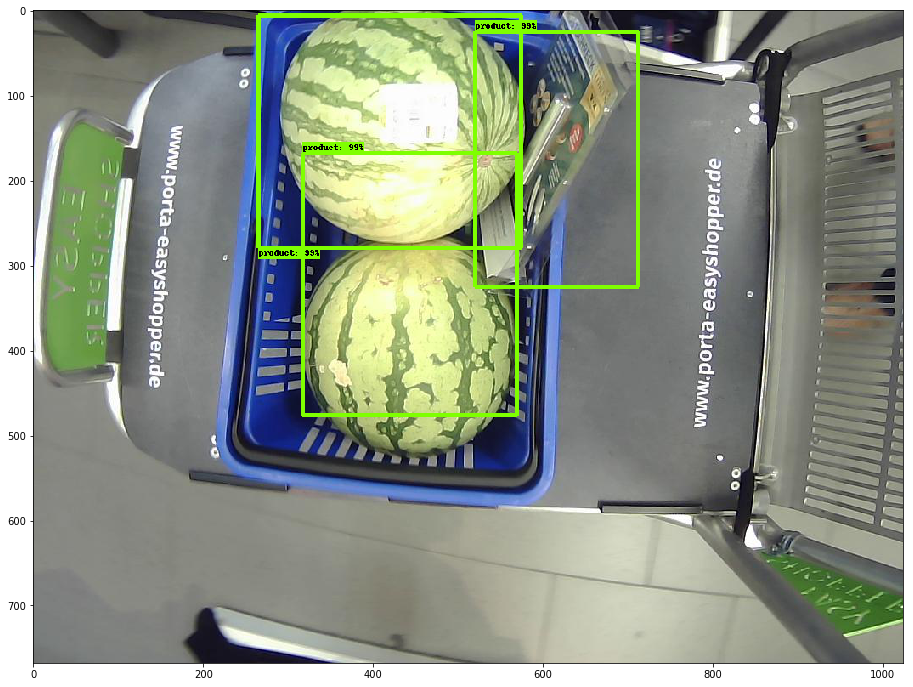

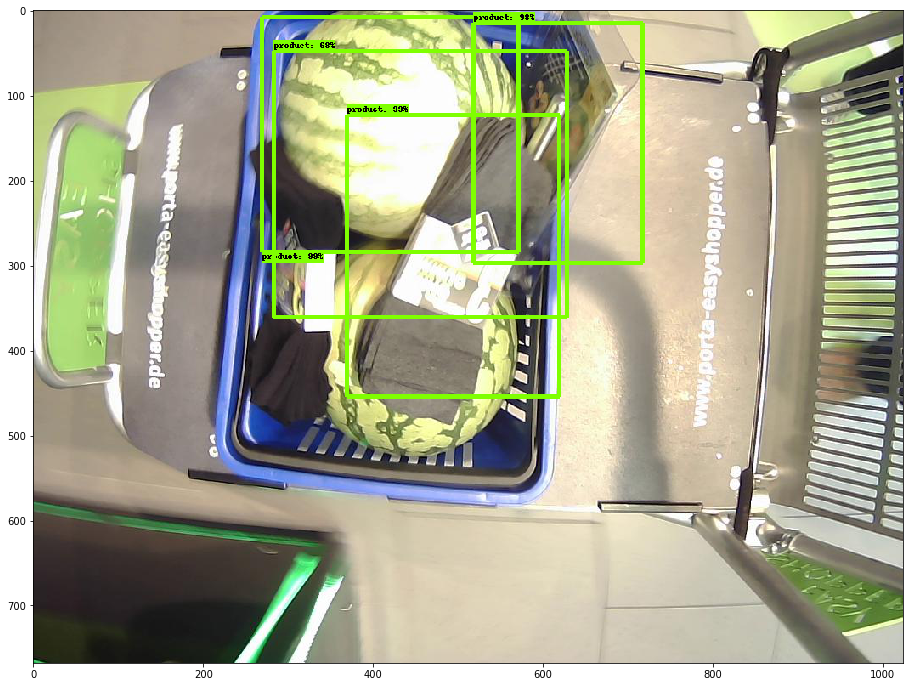

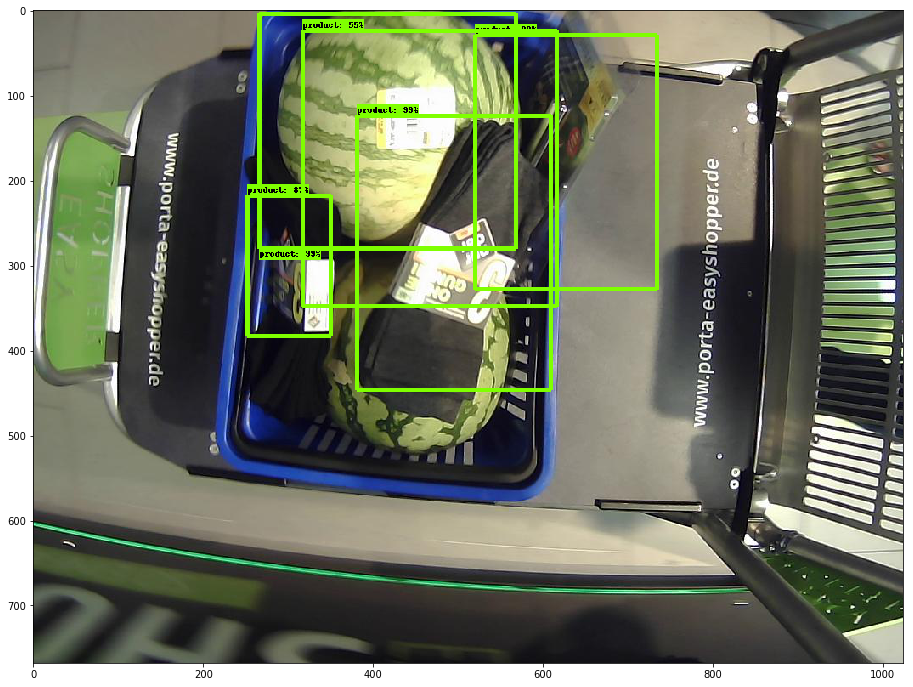

In [29]:
from IPython.display import display, clear_output
clear_output(wait=True)



for image_np, output_dict in outputs:
    not_same = np.where(output_dict["detection_classes"] > 0)
    image_np_out = np.copy(image_np)
    vis_util.visualize_boxes_and_labels_on_image_array(
          image_np_out,
          output_dict['detection_boxes'][not_same],
          output_dict["detection_classes"][not_same],
          output_dict['detection_scores'][not_same],
          category_index,
          use_normalized_coordinates=True,
          line_thickness=5,
          min_score_thresh=.5)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np_out)


In [25]:
# progress = 0

# processed = 0
# time_avg = 0

# outputs = []

# total_time = 0
# with tf.Graph().as_default():
#     od_graph_def = tf.GraphDef()
#     with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
#         serialized_graph = fid.read()
#         od_graph_def.ParseFromString(serialized_graph)
#         tf.import_graph_def(od_graph_def, name='')
    
#     ker_model = load_model(
#         "/home/wc-gpu/MasterThesis/models/research/object_detection/box_classification_checkpoint/keep/2019-02-09weights-epoch194-val_acc0.87-val_loss0.68.hdf5")

#     session_path = "/home/wc-gpu/MasterThesis/session_data/117653/"

#     images = sorted([f for f in os.listdir(session_path) if f.endswith(".jpg")])
#     total_images = len(images)
#     prev_features = None
#     for image_fname in images:
#         has_processed = False
#         try:
#             t0 = time.time()
#             image_path = os.path.join(session_path, image_fname)

#             image = Image.open(image_path)
#             image_np = load_image_into_numpy_array(image)

#             output_dict = run_inference_for_single_image(image_np)
            
#             keep = np.where(output_dict['detection_scores'] > 0.01)
            
#             output_dict['detection_boxes'] = output_dict['detection_boxes'][keep]
#             output_dict['detection_classes'] = output_dict['detection_classes'][keep]
#             output_dict['detection_scores'] = output_dict['detection_scores'][keep]
            
#             if prev_features is not None:
#                 box_features = []
#                 for b in output_dict['detection_boxes']:
#                     box_features.append(max_pooled(prev_features,  output_dict['features'], b))
                
#                 box_features = np.array(box_features)
                
                
#                 predict = ker_model.predict(box_features)
                
# #                 print ("max", max(predict[:, 1]))
#                 cls = np.argmax(predict, -1)
#                 scores = list()
                
#                 for i in range(len(cls)):
#                     scores.append(predict[i][cls[i]])
#                 [0]
#                 print (cls, "\n", scores)
#                 scores = np.array(scores)
#                 wh = np.where(cls==0)
#                 scores[wh] = 0
#                 output_dict['detection_scores'] =  scores * output_dict['detection_scores']
#                 output_dict['detection_classes'] = cls + 1
                
                
#                 has_processed = True
#                 processed += 1
# #                 break
#             prev_features = output_dict['features']            
#             outputs.append((image_np, output_dict))
            
#         except Exception as ex:
#             print ("IMAGE ", image_fname)
#             print (str(ex))
#             raise ex


#         t1 = time.time()

#         total = t1-t0
        
#         if has_processed:
#             time_avg = (total_time + total) / processed
        
#         total_time += total
        
#         log_text = " ".join(["progress ", ":", str(progress / total_images), 
#                              str(progress), str(total_images)])
#         log_text += " | "

#         log_text += "".join(["process time ", str(total)])
#         log_text += " | "
#         log_text += "".join([" time passed: ", str(time_avg*processed) ," s, remaining: ", str(time_avg* (total_images - progress) ), " s"])
            

#         print (log_text, end="                                       \r")

#         progress += 11
        

# # log.close()

